# 𝕃𝕒𝕓#𝟛 - 𝔹𝕒𝕘𝕟𝕒𝕣𝕒, 𝔾𝕒𝕝𝕗𝕣𝕖̀, 𝕄𝕒𝕣𝕔𝕚𝕒𝕟𝕠̀

* Total running time: 4 mins

## Table of Contents:
0. [Task #0](#task#0)
1. [Task #1](#task#1)
2. [Task #2](#task#2)
3. [Task #3](#task#3)
4. [Task #4](#task#4)
5. [Task #5](#task#5)

In [2]:
# importing libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
tqdm.pandas()
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from io import BytesIO
import numpy as np
import spacy # you might need to install it
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
from collections import defaultdict, Counter
import re
import string                             
from nltk.corpus import stopwords 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#pip install wordcloud
#pip install spacy
#pip install nltk
#pip install transformers

# Task#0 : Web scraping tickers and firms' names  <a name="task#0"></a>

In [3]:
# using beautifulsoup to scrape data from wikipedia
URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
r = requests.get(URL)
soup = BeautifulSoup(r.content, 'html.parser')
comp = {}
c = 1
for x in soup.find_all("a", class_ = "external text"):
    if c == 1:
        comp[x.text] = re.sub("(,?\s(Inc.?))|\sCorporation|.com|\sSolutions|", "", x.findNext().text)
        c *= -1
        if x.text == "ZTS":
            break
    else:
        c *= -1
        
len(comp)

503

In [4]:
table = pd.DataFrame(comp.items(), columns = ["Symbol",	"Security"])
tickers = set(table.Symbol)

In [5]:
def clean_firm_name(name):
    """
    further cleaning steps
    """
    name = name.lower() # lower
    name = re.sub(r"\(.+\)", "", name) # remove parentesis
    name = re.sub(r"(?i)inc.?", "", name) # remove inc
    name = re.sub(r"(?i)corporation", "", name) # remove corporation
    name = re.sub(r"(?i)& co.", "", name) # remove & co.
    name = re.sub(r'[.,;]', "", name) # remove punctuation
    name = re.sub(r"(?i)company", "", name) # remove company
    name = re.sub(r"(?i)\bthe\b", "", name) # remove the
    name = name.strip() # removing superfluous spaces
    return name

In [6]:
table["cleanded_security"] = table.Security.apply(clean_firm_name)

In [7]:
table.head()

,Symbol,Security,cleanded_security
0,MMM,3M,3m
1,AOS,A. O. Smith,a o smith
2,ABT,Abbott,abbott
3,ABBV,AbbVie,abbvie
4,ABMD,Abiomed,abiomed


This table will be useful to map each security to its ticker to ease the measures of media attention ([Task #5](#task#5))

# Task #1 : Basic manipulation and descriptive statistics <a name="task#1"></a>

## 1.1 Import the ```Data_PCLab3_Twitter_Stock_Sentiment.csv``` data and describe the sample (data available on BBoard)

In [3]:
data = pd.read_csv("data/lab3/Data_PCLab3_Twitter_Stock_Sentiment.csv") # importing data

In [9]:
# shape description
print("Number of rows (tweets):", data.shape[0])
print("Number of columns:\t", data.shape[1])
data.head()

Number of rows (tweets): 5791
Number of columns:	 2


,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


The provided datasets contains 5791 tweets. For each tweet it provides the text and the sentiment (1 = positive, 0 = negative)

In [10]:
# counting the number of words in each tweet, adding the counter to the dataframe
data["num_words"] = data.Text.apply(lambda x: len(x.split()))
data.head()

,Text,Sentiment,num_words
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,20
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,16
2,user I'd be afraid to short AMZN - they are lo...,1,18
3,MNTA Over 12.00,1,3
4,OI Over 21.37,1,3


In [11]:
# checking if there are null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
 2   num_words  5791 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 135.9+ KB


From the above output we see that _Text_ and _Sentiment_ columns feature 5791 non-null values, therefore we can claimm that there are not missing values in the dataset

In [12]:
# checking that the sentiment is binary
data.Sentiment.unique()

array([1, 0])

The _Sentiment_ column only takes 0-1 values

## 1.2 How many tweets, how many words per tweets, distribution of number of words per tweets, average sentiment, etc.

In [13]:
# importing colors
class color:
    GREEN = '\033[92m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'

# counting the number of positive and negative tweets
print(color.BOLD+"Number of tweets:\t"+color.END, len(data))
print(color.BOLD+color.GREEN+"Positive tweets:\t"+color.END, len(data[data.Sentiment == 1]))
print(color.BOLD+color.RED+"Negatve tweets:\t\t"+color.END, len(data[data.Sentiment == 0]))

Number of tweets:	 5791
Positive tweets:	 3685
Negatve tweets:		 2106


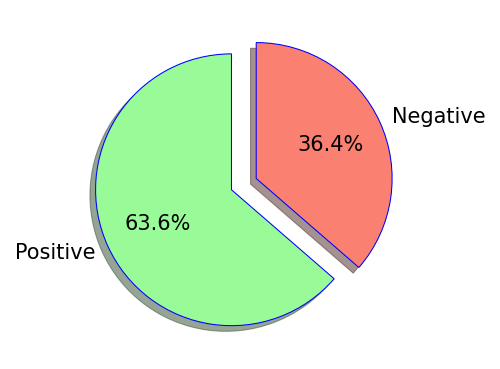

In [14]:
# plotting the pie chart of the % of positive and negative tweets
plt.figure(figsize = (3,3), dpi = 150)
explode = (0.1,0.1)
plt.pie([data.Sentiment.mean(), 1-data.Sentiment.mean()], explode = explode, shadow = True, startangle=90,
       labels = ["Positive", "Negative"], autopct = "%1.1f%%", colors = ["palegreen", "salmon"], 
        wedgeprops={"edgecolor" : "blue", "linewidth":0.5});

As it can be seen, the dataset is slightly unbalanced, since there are more positive tweets than negative ones.\
This is something that might need to be taken into account when training classification models over this datasets.

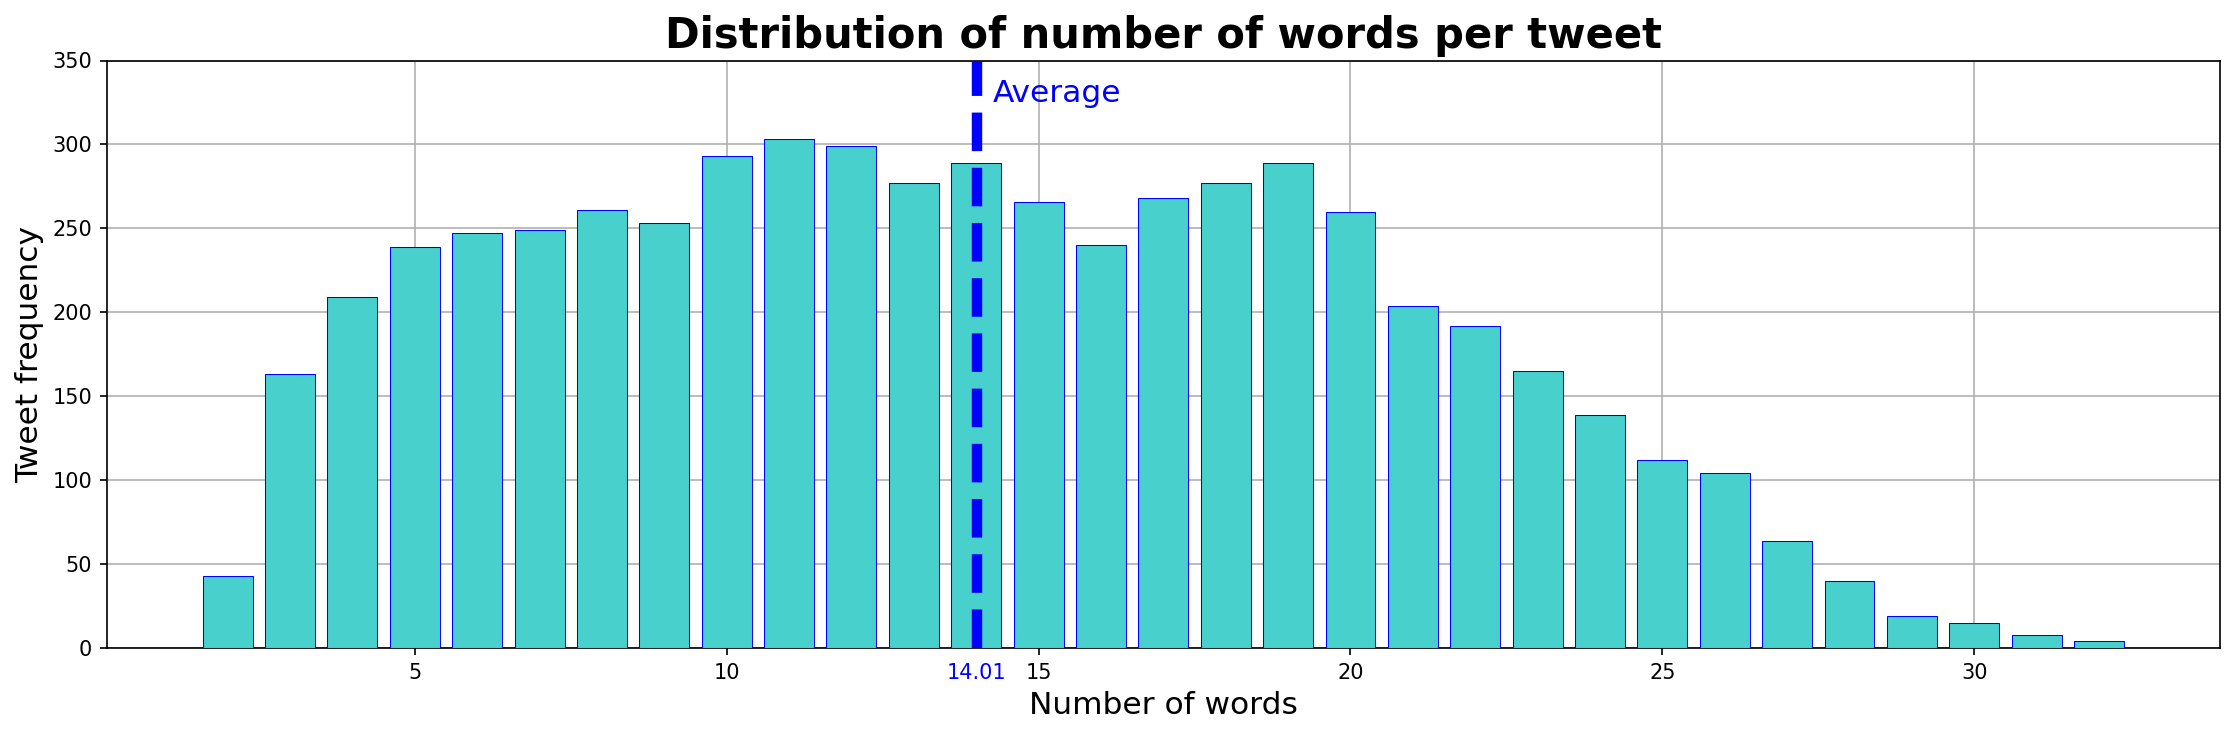

In [15]:
# plotting the distribution of number of words per tweet
plt.figure(figsize = (15, 5), dpi = 150)
avg_num_words = data.num_words.mean() # computing the average number of words per tweet
plt.ylim(0,350)
plt.title("Distribution of number of words per tweet", weight = "bold", fontsize = 20)
plt.bar(data.groupby("num_words").size().index, data.groupby("num_words").size(), zorder = 10, color = "mediumturquoise", edgecolor = "blue", linewidth =0.5)
plt.grid(zorder = -10)
plt.axvline(data.num_words.mean(), zorder = 20, color = "blue", lw = 5, ls = "dashed")
plt.text(avg_num_words + 0.25, 325, "Average", ha = "left", color = "blue", fontsize = 15)
plt.text(avg_num_words, -8.6, np.round(avg_num_words,2), va = "top", ha = "center", zorder = 10, color = "blue")
plt.ylabel("Tweet frequency", fontsize = 15)
plt.xlabel("Number of words", fontsize = 15)
plt.tight_layout()

In the above bar plot we have the distirbution of the lenghts of the tweets. The average length is 14.01 words and the distribition is asymmetric, since the right hand side of the distribution decreases more gradiently.\
Now we plot the same distribution, dividing positive and negative tweets to inspect if there are differences between the two categories.

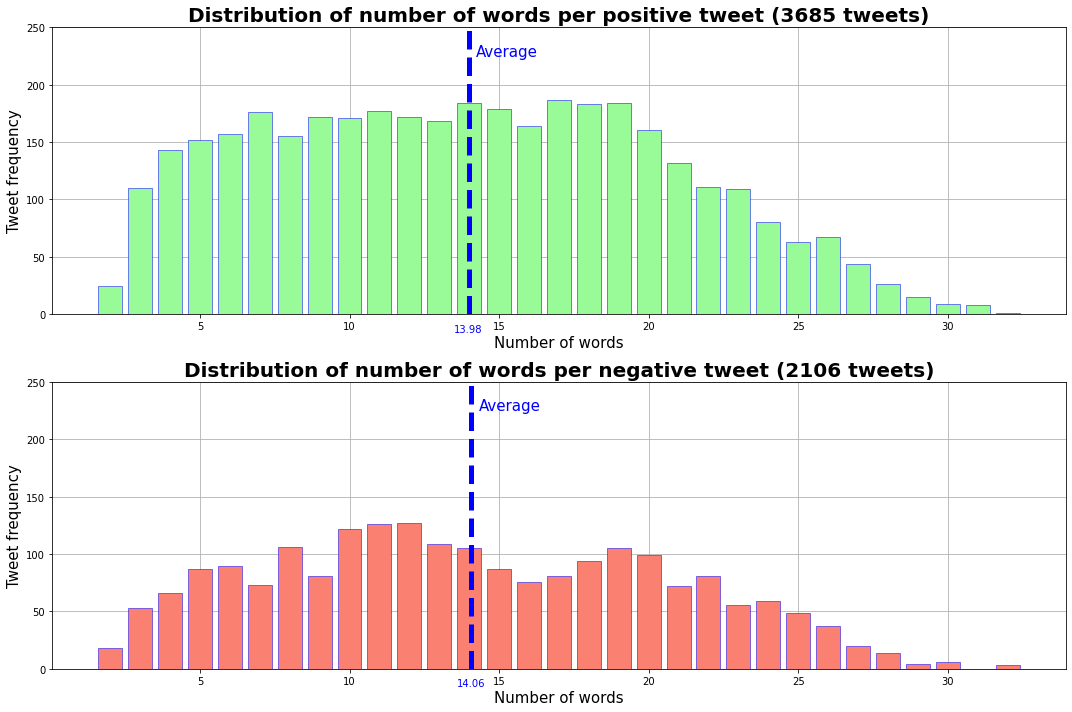

In [16]:
# bar plot of POSITIVE tweets
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
#plt.figure(figsize = (15, 5), dpi = 150)
data_pos = data[data.Sentiment == 1]
avg_num_words = data_pos.num_words.mean()
plt.ylim(0,250)
plt.title(f"Distribution of number of words per positive tweet ({len(data_pos)} tweets)", weight = "bold", fontsize = 20)
plt.bar(data_pos.groupby("num_words").size().index, data_pos.groupby("num_words").size(), zorder = 10, color = "palegreen", edgecolor = "blue", linewidth =0.5)
plt.grid(zorder = -10)
plt.axvline(data_pos.num_words.mean(), zorder = 20, color = "blue", lw = 5, ls = "dashed")
plt.text(avg_num_words + 0.25, 225, "Average", ha = "left", color = "blue", fontsize = 15)
plt.text(avg_num_words, -8.6, np.round(avg_num_words,2), va = "top", ha = "center", zorder = 10, color = "blue")
plt.ylabel("Tweet frequency", fontsize = 15)
plt.xlabel("Number of words", fontsize = 15)

# bar plot of NEGATIVE tweets
plt.subplot(2,1,2)
data_neg = data[data.Sentiment == 0]
avg_num_words = data_neg.num_words.mean()
plt.ylim(0,250)
plt.title(f"Distribution of number of words per negative tweet ({len(data_neg)} tweets)", weight = "bold", fontsize = 20)
plt.bar(data_neg.groupby("num_words").size().index, data_neg.groupby("num_words").size(), zorder = 10, color = "salmon", edgecolor = "blue", linewidth =0.5)
plt.grid(zorder = -10)
plt.axvline(data_neg.num_words.mean(), zorder = 20, color = "blue", lw = 5, ls = "dashed")
plt.text(avg_num_words + 0.25, 225, "Average", ha = "left", color = "blue", fontsize = 15)
plt.text(avg_num_words, -8.6, np.round(avg_num_words,2), va = "top", ha = "center", zorder = 10, color = "blue")
plt.ylabel("Tweet frequency", fontsize = 15)
plt.xlabel("Number of words", fontsize = 15)
plt.tight_layout()

We see that negative tweets show a more ondulatory trend in the words distribution. The highest frequency is 12, while the average lenght is 14.06.\
Instead, positive tweets maximize the frequency at length 17. The average length is 13.98, slighly lower than negative tweets and this is possibly due to a fatter left tail in the distribution.\
Overall, the two distributions cover the same length range (2-32 words).



# Task #2 : Cleaning and visualization <a name="task#2"></a>

## 2.1 Usual <font color='#00807f'> cleaning steps </font> : remove punctuation, stopwords, short words, etc.

In [17]:
# Define a preprocess function
def preprocess(input_text):
    """
    this function receives a string as input and returns a cleaned version
    the transformations are:
      - substitute company names with their ticker (this simplifies the final task)
      - lowercase the words (except for the tickers)
      - substitute numbers with 0 (because we deem numbers to be irrelevant for the text classifcation)
      - remove urls
      - remove punctuation (if not part of the tickers)
      - remove stopwords (if they are not tickers or whitelisted stopwords)
      - lemmatize (that is, reduce each word to its dictionary entry, ie "going", "went", "goes", etc are all transformed into "go)
    """
    txt = input_text
    
    
    # 1. substitute company name with its ticker
    patt = "|".join(table.cleanded_security.to_list()) # pattern for the regular expression
    # this pattern is just the collection of all the companies in the sp500
    patt = r"\b({})\b".format(patt)
    matches = re.findall(patt, txt.lower()) # finds the companies appearing in the given text
    for n in matches:
        tick = table[table.cleanded_security == n].Symbol.iloc[0]   # substitutes company's name with its ticker
        txt = re.sub(n, tick, txt, flags= re.IGNORECASE) 
    # this first preprocessing step is fundamental, and will be useful in the last task, were we are asket
    # to find how many positive/negative tweets there are per each company
    # to do that, we will just look for the tickers present in the tweets

    
    # 2. Normalize to lowercase
    txt = " ".join([i.lower().rstrip(",.'") if i.rstrip(",.'").upper() not in tickers else i.rstrip(",.'").upper() for i in txt.split()])
    
    # 3. Remove numbers (substituted with 0)
    txt = re.sub(r"\d+", "0", txt)
    
    # 4. Remove urls
    txt = re.sub(r'https?://\S+|www\.\S+', '', txt)
    
    # 5. Remove punctuation
    txt = re.sub('\n', '', txt)
    # before removing punctuation we check that it is not part of the ticker
    txt = " ".join([re.sub(r"[^A-Za-z0]+", " ", w) if w not in tickers else w for w in txt.split()])
    
    # 6. Remove stopwords
    # we have identified a set of stopwords that we deem to be relevant (expecially for the classification task)
    # therefore we don't want them to be removed from the corpus
    whitelist = set(['above', 'below','up','down','over','under']) # stopwords we consider meaningful
    stop_words = [w.lower() for w in stopwords.words() if w not in whitelist] # stop words
    txt = ' '.join([w for w in txt.split() if (len(w) >  2 and w not in stop_words) or (w in tickers)])
    
    # 7. Lemmatization
    lemmas = [token.lemma_ if token.text not in tickers else token.text for token in nlp(txt)]
    lemmas = " ".join(lemmas)
    
    # the function finally returns two output:
      # a. the cleaned version of the text
      # b. the lemmatized version
    return txt, lemmas

In [18]:
# preprocessing the entire corpus of tweets (about 2 mins required)
processed = data.Text.progress_apply(preprocess)

  0%|          | 0/5791 [00:00<?, ?it/s]

In [19]:
# adding the cleaned tweets and the lemmatized tweets to the dataset 
data["cleaned_text"] = [tweet[0] for tweet in processed]
data["lemmatized_text"] = [tweet[1] for tweet in processed]
data.head()

,Text,Sentiment,num_words,cleaned_text,lemmatized_text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,20,kickers ON watchlist xide tit soq pnk cpw bpz ...,kicker ON watchlist xide tit soq pnk cpw bpz t...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,16,user AAP movie return fea geed indicator trade...,user AAP movie return fea geed indicator trade...
2,user I'd be afraid to short AMZN - they are lo...,1,18,user afraid short AMZN ARE A monopoly ebooks i...,user afraid short AMZN ARE A monopoly ebook in...
3,MNTA Over 12.00,1,3,mnta over,mnta over
4,OI Over 21.37,1,3,over,over


## 2.2 Try your cleaning on this sentence : 

```$I love AI & Machine learning applied to Finance...!! ;)```

In [20]:
# try the performance of the function over a sampel sentence
preprocess("$I love AI & Machine learning applied to Finance...!! ;)")

('love machine learning applied finance',
 'love machine learning apply finance')

The ```preprocess``` function seems to work properly. Moreover, as it can be seen from the output below, the word _applied_ is transformed into _apply_ in the second part of the output

## 2.3 Plot a <font color='#00807f'> word cloud </font>  for text with positive and negative sentiment separately

In [21]:
def wordchipcloud(text, mask=None, max_words=200, max_font_size=100, color = 'white',
                   title = None, title_size=40, colormap = "Greens", contour = False):
    """
    this function creates a wordcloud starting from a given text corpus
    the shape of the cloud can be provided with the url of an image
    the function also receives other parameters to set the propter size
    """
    if contour: # we can also draw the countour (default False)
        contour_width = 0.5
    else:
        contour_width = 0
        
    wordcloud = WordCloud(background_color=color,
                    max_font_size = max_font_size, 
                    random_state = 810,
                    width=200, 
                    height=100,
                    mask = mask,
                    contour_color = "blue",
                    contour_width = contour_width)
    wordcloud.generate(str(text))
    
    
    plt.imshow(wordcloud.recolor(colormap = colormap), interpolation="bilinear");
    plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'top'}, pad = 30)

    plt.axis('off');
    plt.tight_layout()

In [22]:
url = "https://cdn-icons-png.flaticon.com/512/733/733635.png" # url of the image to be used as the shape of the cloud
response = requests.get(url)
pos_mask = np.array(Image.open(BytesIO(response.content))) # importing the image from the url
new_mask = pos_mask

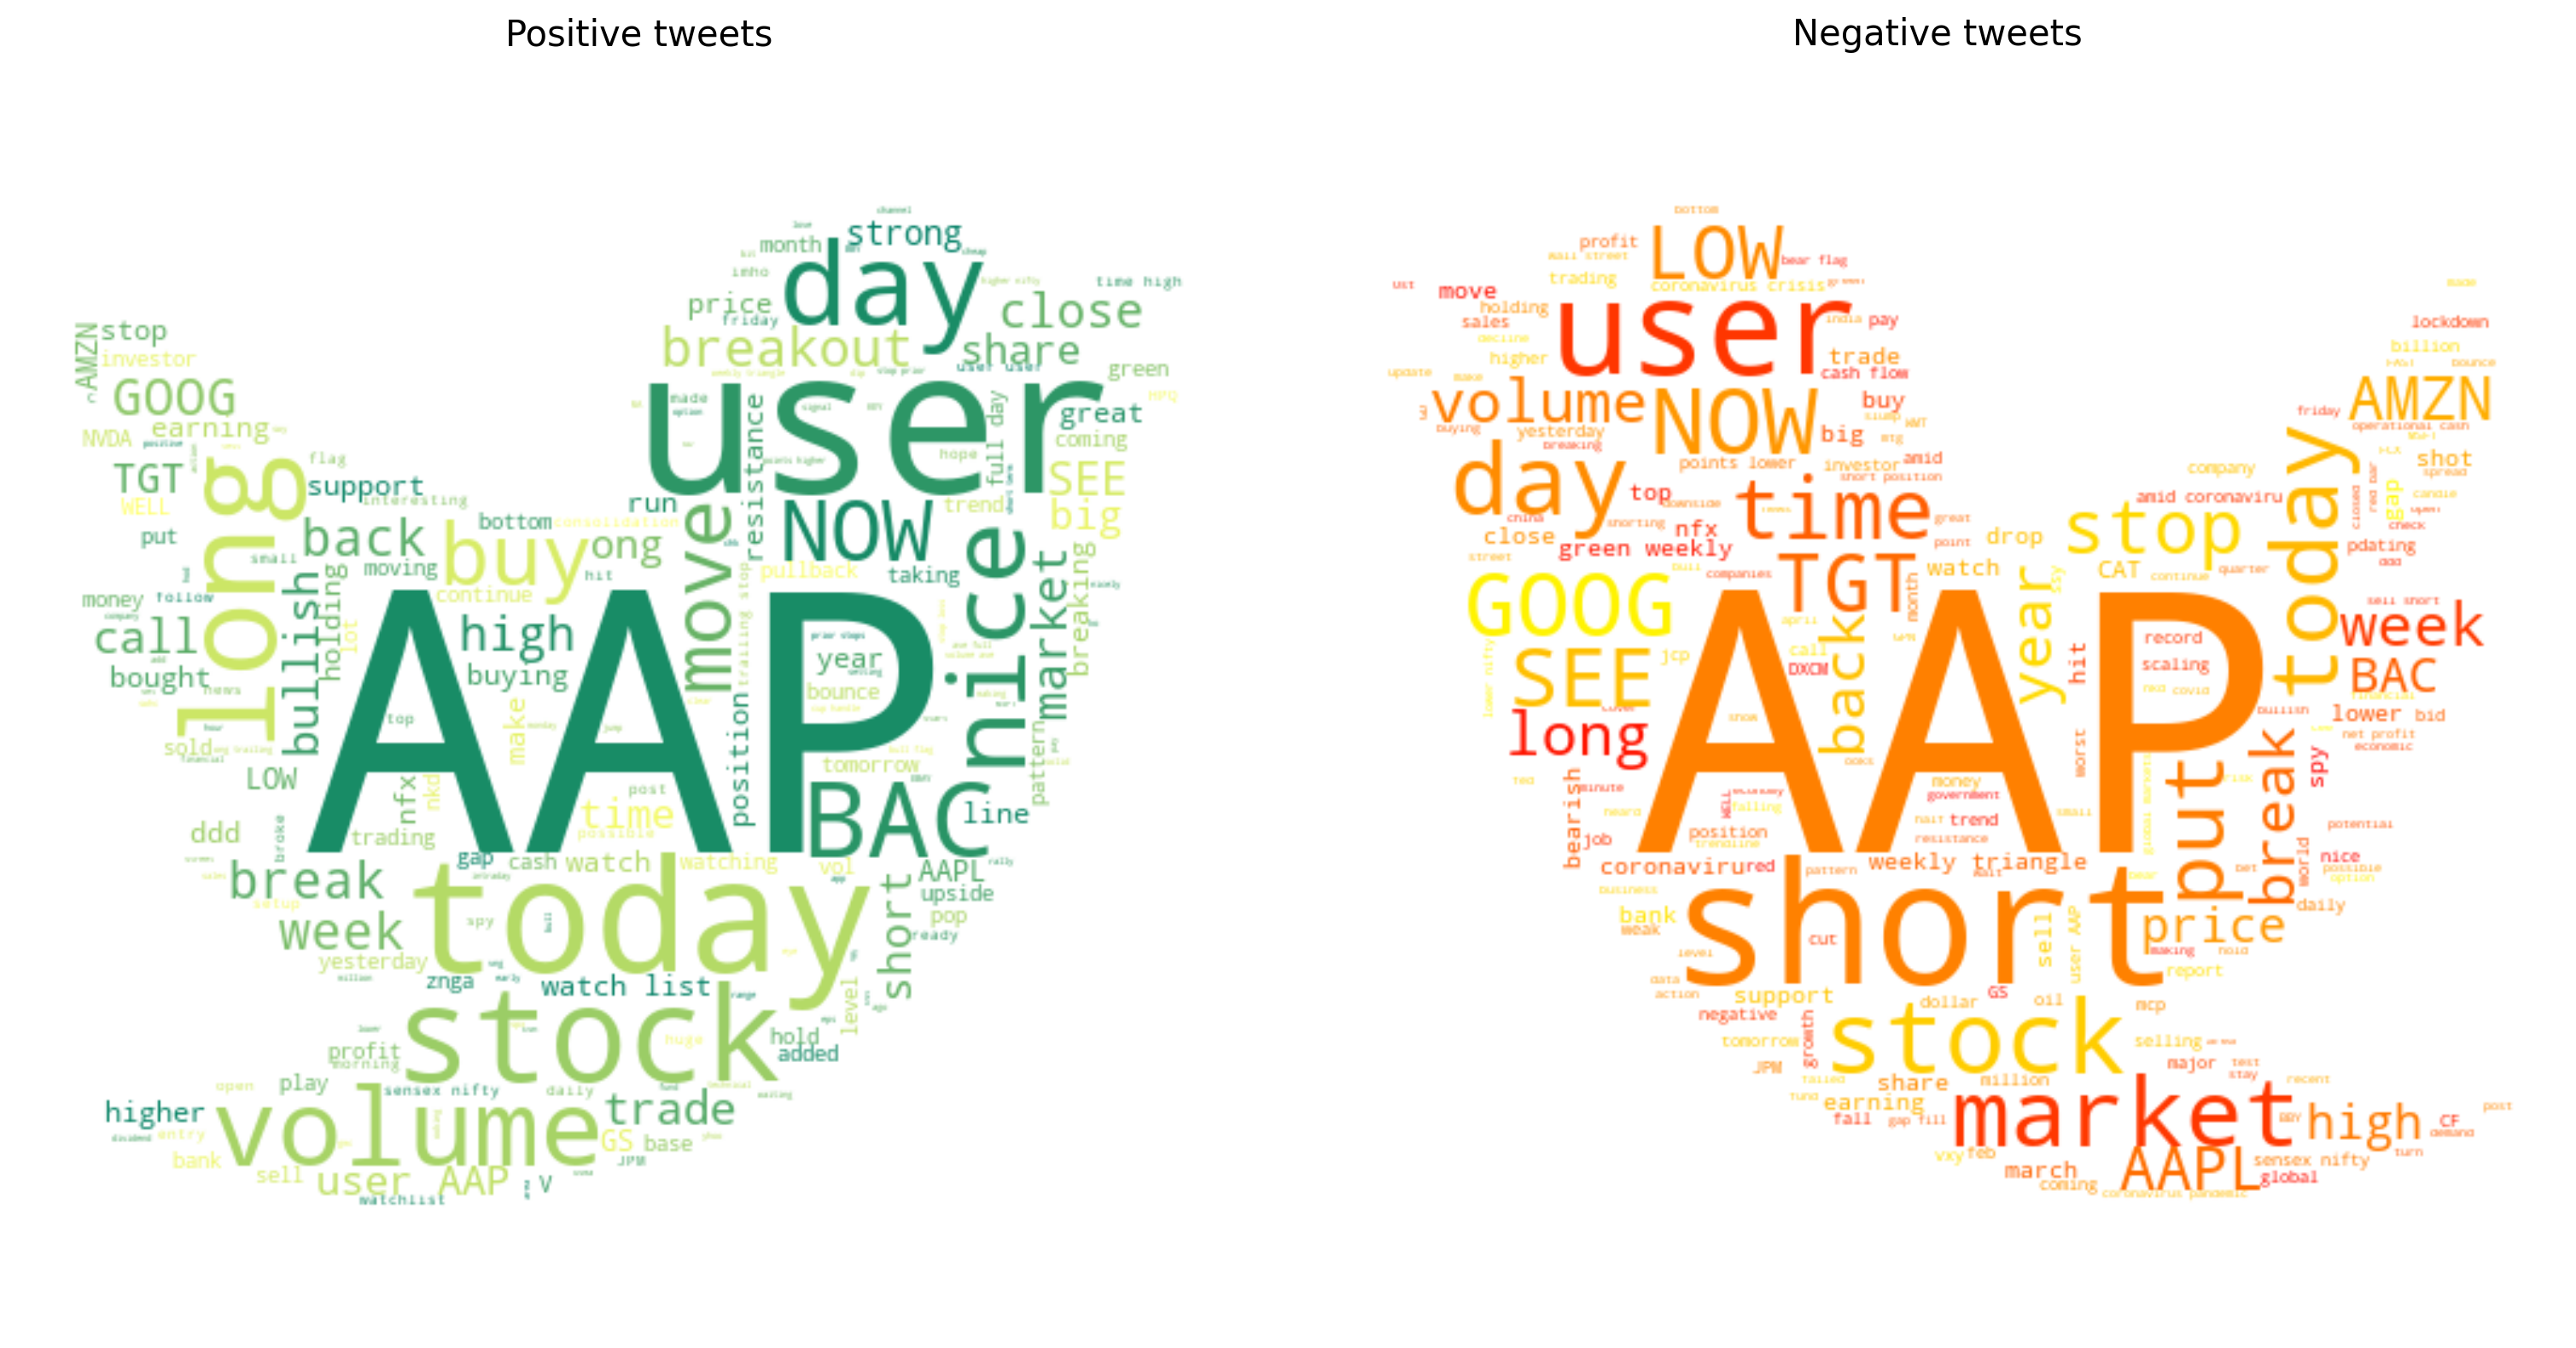

In [23]:
# plotting the world cloud for positive and negative tweets
# retreving the text of positive tweets as an unique string
pos = " ".join(data.cleaned_text[i] for i in range(len(data)) if data.Sentiment[i] == 1)

 # retreving the text of negative tweets as an unique string
neg = " ".join(data.cleaned_text[i] for i in range(len(data)) if data.Sentiment[i] == 0)
plt.figure(figsize = (16,8), dpi = 200)
plt.subplot(1,2,1)
wordchipcloud(pos, mask=new_mask,color='white',max_font_size=150,title_size=15, colormap="summer", title="Positive tweets", contour = False)
plt.subplot(1,2,2)
wordchipcloud(neg, mask=np.fliplr(new_mask),color='white',max_font_size=150,title_size=15, colormap="autumn", title="Negative tweets", contour = False)
plt.tight_layout()

From this simple visualization we can already identify some words that are more representative of positive or negative tweets. For example _buy_, _nice_, _long_ are very present in the left hand side plot (positve tweets), while _short_, _low_, _stop_ are very present in the right hand side plot (negative tweets).\
It seems like _AAP_ (Advance Auto Parts) is a very overall discussed stock, regardless of the tweet sentiment.

## 2.4 What is the number of unique words? 

In [24]:
def unique_words(col):
    """
    this function takes a column tag of the dataset
    (either the original text, the cleaned version or the lemmatized one)
    it returns the number of unique words present in the specified text
    """
    # merging all the tweets into a unique string
    s = " ".join(data[col][i] for i in range(len(data)))

    return len(set(s.split()))

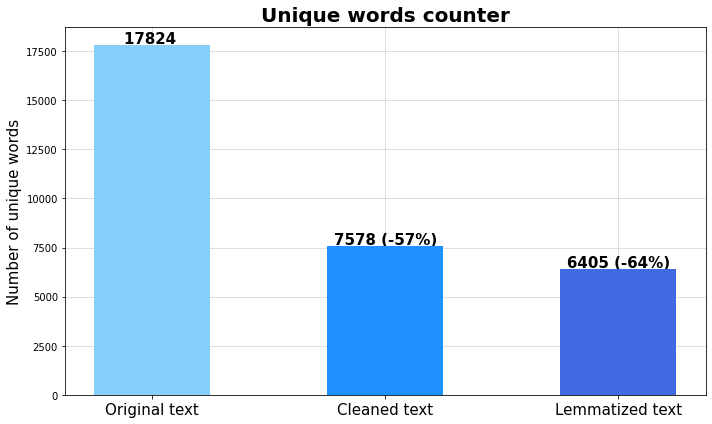

In [25]:
# plotting the bar plot of the number of unique words in the three types of texts
plt.figure(figsize = (10, 6))
plt.title("Unique words counter", weight = "bold", fontsize = 20)

# building the dictionary with the number of unique words per each text category
data_dic = {"Original text":unique_words("Text"),
            "Cleaned text":unique_words("cleaned_text"),
            "Lemmatized text":  unique_words("lemmatized_text")}

plt.bar(data_dic.keys(),
        data_dic.values(),
        width=0.5,
        color = ["lightskyblue", "dodgerblue", "royalblue"], zorder = 10)
plt.ylabel("Number of unique words", size = 15)
plt.xticks(size = 15)

# writing the label and the counts on the plot
for i,k in enumerate(data_dic.keys()):
    if i != 0:
        change = "("+str(int(((data_dic[k] - data_dic["Original text"])/data_dic["Original text"])*100))+"%)"
    else:
        change = ""
        
    plt.text(i, data_dic[k]+100, str(data_dic[k]) + " " + change, ha = "center", weight = "bold", fontsize = 15)
plt.grid(alpha = 0.5, zorder = -10)
plt.tight_layout()

As it can be noticed there are 17,824 unique words in the original text. In the cleaned version there are 7,578 unique words (-57% relatively to the original version), the reduction is mainly due to the fact that we removed stopwords and short words. Finally in the lemmatized corpus there are 6,405 unique words (-64% relatively to the original version), because different words are reduced to the same dictionary rood, therefore reducing the number of unique words present in the corpus.

# Task #3 : Sentiment analysis <a name="task#3"></a>

## 3.1 Split the sample in a train / test dataset (test = 10% of the total sample)

In [26]:
target = 'Sentiment'
input_column = 'cleaned_text'

df_data = data[[input_column, target]]

In [27]:
from sklearn.model_selection import train_test_split

# splitting our dataset

train_data, test = train_test_split(df_data, test_size=0.2, random_state=123)
dev_data, test_data = train_test_split(test, test_size = 0.5, random_state=123)
# we also used a development dataset (10%), used to fine tune the parameters
# the test dataset (10%) is used only at the end of the whole process to check the performance
# of the models over fresh new data

## 3.2 More usual steps : Tokenizing the text and padding
- Tokenize : vectorize text corpus, transform text into numbers

- Padding : make all sentences the same lenght (fill with 0 short sentences)


In [28]:
# collect known word tokens and tags
wordset, labelset = set(), set()

# collect tags from all data, to prevent unseen labels
labelset.update(set(data[target]))

train_instances = train_data[input_column].apply(str).apply(str.split)
train_labels = train_data[target]

# get the vocabulary
for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
label2int = {label: i for i, label in enumerate(sorted(labelset))}
# inverted index to translate it back
int2label = {i:label for label, i in label2int.items()}

In [29]:
def convert2ints(instances):
    """
    function to apply the mapping to all words
    """
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        result.append(word_ints)
    return result

# convert train data
train_instances_int = convert2ints(train_instances)
train_labels_int = [label2int[label] for label in train_labels]

# convert dev data
dev_instances = dev_data[input_column].apply(str).apply(str.split)
dev_labels = dev_data[target]

dev_instances_int = convert2ints(dev_instances)
dev_labels_int = [label2int[label] for label in dev_labels]

# convert test data 
test_instances = test_data[input_column].apply(str).apply(str.split)
test_labels = test_data[target]

test_instances_int = convert2ints(test_instances)
test_labels_int = [label2int[label] for label in test_labels]

In [30]:
# Neural Networks models need 1-hot labels encoding 
from tensorflow.keras.utils import to_categorical

train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))

train_labels_1hot[0]

array([0., 1.], dtype=float32)

In [31]:
# compute 95th percentile of training sentence lengths
L = sorted(map(len, train_instances))
MAX_LENGTH = L[int(len(L)*0.95)]
print(MAX_LENGTH) # i want all the instances to be long as this max lenght

# apply padding
from keras.preprocessing.sequence import pad_sequences
train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH)
test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)
dev_instances_int = pad_sequences(dev_instances_int, padding='post', maxlen=MAX_LENGTH)

print(train_instances[0], len(train_instances[0]))
print(train_instances_int[0], len(train_instances_int[0])) # the instances are now padded

14
['kickers', 'ON', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'SEE', 'prev', 'posts'] 15
[3849 4275 6194 5777 4754 5781    0    0    0    0    0    0    0    0] 14


## 3.3 Train model of your choice (RNN, LTSM, etc.) to predict the sentiment (1 or 0) on the test sample (you could use embedding layer to reduce the dimension of the problem)


In [32]:
# create dictionary to store scores
test_scores = {}

### 3.3.1 Most Frequent Label Baseline
We initially classified the tweets using the Most Frequent Label classifier (in this case, it will predict all positive), which we then used as a baseline to compare the performance of our classifiers. 

To use this model, we need to input a TFIDF (Term Frequency - Inverse Document Frequency) vectorized version of our tweets. TF-IDF is a very common algorithm to transform text (in our case tweets) into a meaningful representation of numbers which is used to fit machine algorithm for prediction. In particular, it uses the frequency of words to determine how relevant those words are to a given document.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# defining the vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.7, 
                             analyzer='word',
                             sublinear_tf=True
                            )

# transforming the train dataset using the vectorizer
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
print(X_train.shape)

(4632, 1601)


In [34]:
# transforming the dev and test dataset using the vectorizer
X_dev = vectorizer.transform(dev_data['cleaned_text'])
X_test = vectorizer.transform(test_data['cleaned_text'])
print(X_dev.shape, X_test.shape)

(579, 1601) (580, 1601)


In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

# find the most frequent class in the training data
most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, train_labels)

# get the performance on the development set
dumb_predictions = most_frequent.predict(X_dev)
print(classification_report(dev_labels, dumb_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.66      1.00      0.79       381

    accuracy                           0.66       579
   macro avg       0.33      0.50      0.40       579
weighted avg       0.43      0.66      0.52       579



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# storing the test predictions
dumb_predictions_fin = most_frequent.predict(X_test)

# storing the performance
test_scores['Most frequent label'] = accuracy_score(test_labels, dumb_predictions_fin)

In [37]:
print(f"Accuracy score of Most Frequent baseline prediction on test data: {np.round(accuracy_score(test_labels, dumb_predictions_fin),2)}")

Accuracy score of Most Frequent baseline prediction on test data: 0.65


### 3.3.2 CNN
Secondly, we run a CNN to see whether a Neural Network structure improve the performance of our prediction. 
We have achieved an increase of more than 10% in accuracy on the test data compared to the baseline. We tried different network structure and configurations (ie different parameters and type of layers) keeping the structure that better performed over the validation dataset.

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation

# make it repeatable
np.random.seed(42)

# set parameters of matrices and convolution
embedding_dim = 64
nb_filter = 64
filter_length = 12
hidden_dims = 128
stride_length = 1


inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs) # functional view
# these are the inner layers
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=stride_length)(embeddings)
convolution2 = Activation(activation='relu')(convolution)
pooling = GlobalMaxPooling1D()(convolution2)
dropout1 = Dropout(0.5)(pooling)
dense = Dense(hidden_dims, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense)
output = Dense(len(label2int), activation='softmax')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model information about layers and parameters
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 14)]              0         
                                                                 
 embedding (Embedding)       (None, 14, 64)            431744    
                                                                 
 conv1d (Conv1D)             (None, 14, 64)            49216     
                                                                 
 activation (Activation)     (None, 14, 64)            0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

In [39]:
# batch size can have a huge effect on performance!
batch_size = 10 # i'm updating after k instances
epochs = 4 # number of iterations

history = model.fit(train_instances_int, train_labels_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(dev_instances_int, dev_labels_1hot)
                   )

loss, accuracy = model.evaluate(test_instances_int, test_labels_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/4
464/464 [==============================] - 6s 10ms/step - loss: 0.6118 - accuracy: 0.6593 - val_loss: 0.5092 - val_accuracy: 0.7772
Epoch 2/4
464/464 [==============================] - 4s 10ms/step - loss: 0.3801 - accuracy: 0.8392 - val_loss: 0.4853 - val_accuracy: 0.7858
Epoch 3/4
464/464 [==============================] - 4s 9ms/step - loss: 0.1932 - accuracy: 0.9290 - val_loss: 0.6457 - val_accuracy: 0.7565
Epoch 4/4
464/464 [==============================] - 4s 9ms/step - loss: 0.1071 - accuracy: 0.9616 - val_loss: 0.8673 - val_accuracy: 0.7478

Testing Accuracy:  0.8155


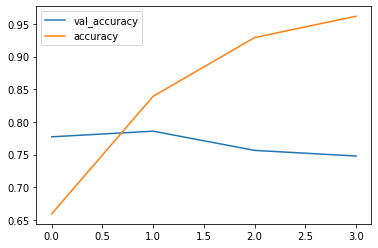

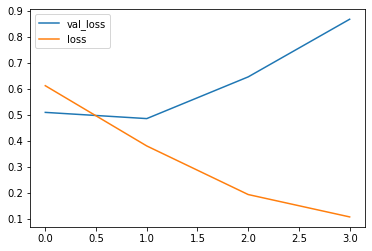

In [40]:
# plotting the performance (accuracy & loss) of the model throughout the iterations
%matplotlib inline
df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [41]:
# storing the test predictions
predictions_cnn = [el.argmax() for el in model.predict(test_instances_int)]

# storing the performance
test_scores['CNN'] = accuracy_score(test_labels, predictions_cnn)

In [42]:
print(f"Accuracy score of CNN prediction on test data: {np.round(accuracy_score(test_labels, predictions_cnn),2)}")

Accuracy score of CNN prediction on test data: 0.82


### 3.3.3 Logistic Regression (TFIDF-words)
Then, we tried some simpler classifier such as Logistic Regression. Also in this case the performance increased a lot compared to the baseline, however the accuracy score is quite similar to the one achieved with CNN.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# defining the Logistic model
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)

LogisticRegression()

In [44]:
predictions = classifier.predict(X_dev)
print(classification_report(dev_labels, predictions))

              precision    recall  f1-score   support

           0       0.76      0.58      0.66       198
           1       0.81      0.91      0.85       381

    accuracy                           0.79       579
   macro avg       0.78      0.74      0.76       579
weighted avg       0.79      0.79      0.79       579



In [45]:
# accuracy over the dev dataset
accuracy_score(dev_labels, predictions)

0.7944732297063903

#### GridSearch for parameter tuning
In order to improve the performance of our classifier, we performed some parameter tuning using GridSearchCV. In this way, we were able to select the most appropriate penalty and C-value (smaller C specify stronger regularization).

In [46]:
from sklearn.model_selection import GridSearchCV


grid_param = { "penalty": ['l2', 'l1'],
             "C": [30, 20, 10, 7, 5, 1, 0.5, 0.1]}

gridsearch = GridSearchCV(LogisticRegression(max_iter = 500, solver = 'liblinear'), param_grid = grid_param,
                             cv = 5, verbose = 1, n_jobs = -1, scoring = "f1_micro")
gridsearch.fit(X_train, train_labels)
best = gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [47]:
# chosen parameters
gridsearch.best_params_

{'C': 5, 'penalty': 'l2'}

To further improve the accuracy we also selected the best threshold used for prediction. The logistic regression assigns each row a probability of bring True and then makes a prediction for each row where that prbability is $>=$ 0.5 i.e. 0.5 is the default threshold. By changing this threshold we were able to rebalance the fraction of False Positive and False Negative, improving a bit the performance.

In [48]:
THRESHOLD = np.arange(0.1,0.9,0.01)
preds_cv = {}

for t in THRESHOLD:
    predictions_lr = np.where(best.predict_proba(X_dev)[:,1] > t, 1, 0)
    preds_cv[t] = accuracy_score(dev_labels, predictions_lr)
    
best_threshold, accuracy = Counter(preds_cv).most_common(1)[0]

In [49]:
best_threshold, accuracy

(0.3999999999999998, 0.7892918825561313)

In [50]:
# storing the test predictions
pred_final_word = np.where(best.predict_proba(X_test)[:,1] > best_threshold, 1, 0)

# storing the performance
test_scores['Logistic Regression word'] = accuracy_score(test_labels, pred_final_word)

In [51]:
print(f"Accuracy score of Logistic Regression (with words-TFIDF) prediction on test data: {np.round(accuracy_score(test_labels, pred_final_word),2)}")

Accuracy score of Logistic Regression (with words-TFIDF) prediction on test data: 0.8


### 3.2.4 Logistic Regression (TFIDF n-grams)

We created the TFIDF matrix with 2-8 gram character (instead of words) that we will use as design matrix for our estimators and then we used it as input for Logistic Regression classification.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_ng = TfidfVectorizer(ngram_range=(2,8), 
                             min_df=0.001,
                             max_df=0.85,
                             analyzer='char',
                             sublinear_tf=True
                            )

X_train_ng = vectorizer_ng.fit_transform(train_data['cleaned_text'])
print(X_train_ng.shape)

(4632, 36147)


In [53]:
X_dev_ng = vectorizer_ng.transform(dev_data['cleaned_text'])
X_test_ng = vectorizer_ng.transform(test_data['cleaned_text'])
print(X_dev_ng.shape, X_test_ng.shape)

(579, 36147) (580, 36147)


In [54]:
log_ng = LogisticRegression(n_jobs=-1,multi_class='auto', solver='lbfgs',penalty = 'l2')
%time log_ng.fit(X_train_ng, train_labels)
print(log_ng)

CPU times: user 22.5 ms, sys: 9.13 ms, total: 31.6 ms
Wall time: 914 ms
LogisticRegression(n_jobs=-1)


In [55]:
predictions_ng = log_ng.predict(X_dev_ng)
print(classification_report(dev_labels, predictions_ng))

              precision    recall  f1-score   support

           0       0.77      0.54      0.63       198
           1       0.79      0.92      0.85       381

    accuracy                           0.79       579
   macro avg       0.78      0.73      0.74       579
weighted avg       0.78      0.79      0.77       579



In [56]:
accuracy_score(dev_labels, predictions_ng)

0.7858376511226253

#### GridSearch for parameter tuning

In [57]:
from sklearn.model_selection import GridSearchCV

grid_param_lr = { "penalty": ['l2', 'l1'],
             "C": [30, 20, 10, 7, 5, 1, 0.5, 0.1]}

gridsearch_lr = GridSearchCV(LogisticRegression(max_iter = 500, solver = 'liblinear'), param_grid = grid_param_lr,
                             cv = 5, verbose = 1, n_jobs = -1, scoring = "f1_micro")
gridsearch_lr.fit(X_train_ng, train_labels)
best_lr = gridsearch_lr.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [58]:
# chosen parameters
gridsearch_lr.best_params_

{'C': 30, 'penalty': 'l2'}

In [59]:
# threshold tuning

THRESHOLD = np.arange(0.1,0.9,0.01)
preds_cv = {}

for t in THRESHOLD:
    predictions_lr = np.where(best_lr.predict_proba(X_dev_ng)[:,1] > t, 1, 0)
    preds_cv[t] = accuracy_score(dev_labels, predictions_lr)
    
best_threshold, accuracy = Counter(preds_cv).most_common(1)[0]

In [60]:
best_threshold, accuracy

(0.2599999999999999, 0.7875647668393783)

The best models using Logistic Regression as classifier using dev_data seems to be a the one with l2 regularization and using as input features a TFIDF matrix (with words) representation of the tweet text. So we finally test our performance on the test_data and store the accuracy score.

In [61]:
# storing the test predictions
pred_final_lr = np.where(best_lr.predict_proba(X_test_ng)[:,1] > best_threshold, 1, 0)

# storing the performance
test_scores['Logistic Regression ng'] = accuracy_score(test_labels, pred_final_lr)

print(classification_report(test_labels,pred_final_lr))

              precision    recall  f1-score   support

           0       0.80      0.49      0.61       202
           1       0.77      0.94      0.85       378

    accuracy                           0.78       580
   macro avg       0.79      0.71      0.73       580
weighted avg       0.79      0.78      0.76       580



In [62]:
print(f"Accuracy score of Logistic Regression prediction on test data: {np.round(accuracy_score(test_labels, pred_final_lr),2)}")

Accuracy score of Logistic Regression prediction on test data: 0.78


## 3.2.5 Final comparison of our classification models
At the end, the CNN turned out to be the best classifier for our test data, with an accuracy score of 82% (this result can slightly change due to the randomness of the model), significantly increasing the performance relative to the baseline.

In [63]:
df_scores = pd.DataFrame([test_scores]).T.rename(columns = {0:'Accuracy on test set'})
df_scores

,Accuracy on test set
Most frequent label,0.651724
CNN,0.815517
Logistic Regression word,0.801724
Logistic Regression ng,0.781034


At the end, we used the confusion matrix to define the performance of a classification algorithm, showing the false positives and false negatives.

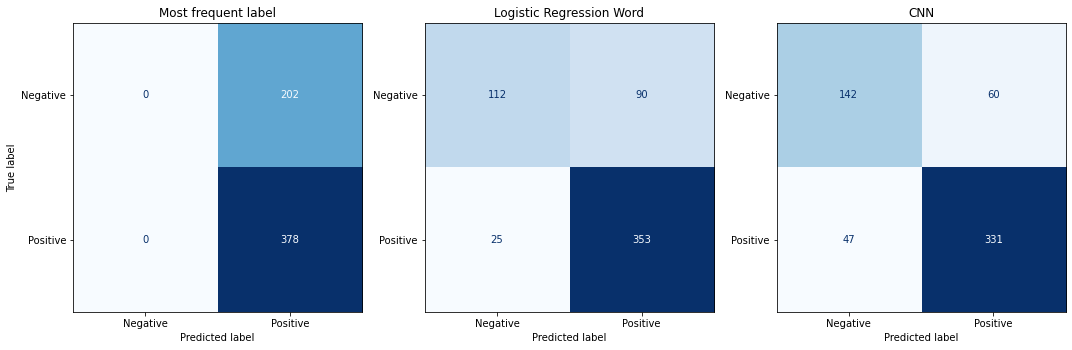

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f, axes = plt.subplots(1, 3, figsize = (15,7))

all_pred = {'Most frequent label':dumb_predictions_fin, 'Logistic Regression Word':pred_final_word, 'CNN':predictions_cnn}

for i, pred in enumerate(all_pred.items()):
    cm = confusion_matrix(test_labels, pred[1], labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative','Positive'])
    disp.plot(cmap=plt.cm.Blues, ax = axes[i])
    disp.ax_.set_title(pred[0])
    disp.im_.colorbar.remove()
    if i!=0:
        disp.ax_.set_ylabel('')
    plt.tight_layout()

The CNN turned out to be the best classifier for our test data, with an accuracy score of 80%, significantly increasing the performance relative to the baseline. Also the LogisticRegression was able to reach a good performance, but slighly lower.

# Task #4 <a name="task#4"></a>

## 4.1 Use transformers (BERT from Huggingface) to perform another sentiment analysis and compare to the sentiment value in the data

BERT (Bidirectional Encoder Representations from Transformers) is a language model proposed by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova in 2018 and pretrained on a huge corpus from Toronto Book Corpus and Wikipedia. It currently represents the state-of-the-art model for multiple Natural Language Processing tasks, including classification and sentiment analysis, therefore we decided to compare its predictions with our models to see whether it was possible to further improve the accuracy our results.

In [65]:
# create dictionary to store scores
test_scores_2 = {}

In [95]:
# pip install transformers

In [68]:
# remember to pip install the transformers library first, and then create a classifier object for sentiment analysis
from transformers import pipeline

classifier = pipeline("text-classification")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [69]:
# again, we specify our target and input.
# BERT should take raw text as input, therefore we are passing the original tweets directly.
target2 = 'Sentiment'
input_column2 = 'Text'
np.random.seed(810)

df_data2 = data[[input_column2, target2]]

# shuffling tweets and creating train (80%), dev (10%) and test (10%) splits
df_data2.sample(frac=1,random_state=810,replace=True)
train_data2, test2 = train_test_split(df_data2, random_state= 810, test_size=0.2)
dev_data2, test_data2 = train_test_split(test2, random_state= 810, test_size = 0.5)

In [70]:
def BERT(s):
    """
    This function returns 1 if BERT label the tweet as "Positive", 0 otherwise.
    """
    return 1 if classifier(s)[0]["label"] == "POSITIVE" else 0

In [71]:
bert_pred = test_data2.Text.progress_apply(BERT)

  0%|          | 0/580 [00:00<?, ?it/s]

In [72]:
# printing the score
accuracy_score(test_data2.Sentiment, bert_pred)

0.503448275862069

In [73]:
# saving the score into the dataframe
test_scores_2['BERT'] = accuracy_score(test_data2.Sentiment, bert_pred)

## 4.2 What is the performance of the algorithm on financial tweets ? I.e., how does BERT classify the Tweets compared to the original classification you have ?
BERT's performance is clearly not as satisfacory as our models', reaching just over 50% of accuracy and falling far behind our benchmark. Naturally, this is likely due to the fact that this is a pretrained model which was not especially designed to classify finance-related tweets.

## 4.3 To go further : check FinBERT

However, a more appropriate pretrained model is available: FinBERT. This model was created further training BERT in the finance domain, using a large financial corpus and fine-tuning it specifically for financial sentiment classification.

In [74]:
from transformers import BertTokenizer, BertForSequenceClassification

# creating the finbert tokenizer and classifier objects
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

Downloading:   0%|          | 0.00/533 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [75]:
def FINBERT(s):
    """
    This function returns 1 if FinBERT label the tweet as "Positive", 0 otherwise
    """
    inputs = tokenizer(s, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]
    if outputs[0][1] >= outputs[0][2]:
        return 1
    else:
        return 0
    
# Notice FinBERT classifies text either as Positive, Negative or Neutral, provinding a softmax outputs for each of the
# possible labels. However, because we are assuming any tweet can either be Positive or Negative only, we return the label
# corresponding to the highest softmax output between the two.

In [76]:
finbert_pred = test_data2.Text.progress_apply(FINBERT) # again, we are passing the original tweets directly

  0%|          | 0/580 [00:00<?, ?it/s]

In [77]:
# printing the score
accuracy_score(test_data2.Sentiment,finbert_pred)

0.6189655172413793

In [78]:
# saving the score
test_scores_2['FinBERT'] = accuracy_score(test_data2.Sentiment, finbert_pred)

FinBERT is significantly better than its general counterpart, coherently with the fact the tweets is definately more in line with FinBERT's expected input. The proformance rises to just over 60% of accuracy (~20% improvement over the previous model), but still less than our benchmark.

## 4.5 nltk Vader classifier

Finally, the last model we considered was Vader, from the nltk library. Vader was defined by its authors as "A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text" (Hutto, C.J. & Gilbert, E.E., 2014). Roughly speaking, this model uses a list of human-chosen lexical features and gives a polarity score to each input based on the nature of the words included, and returns either a "Positive" or "Negative" label.

In [80]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# creating the sid object, and applying the polarity score to each tweet.

sid = SentimentIntensityAnalyzer()
scores = test_data2.Text.apply(lambda x: sid.polarity_scores(x)) # again, we are passing the original tweets directly

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [81]:
vader = pd.DataFrame()
compound  = scores.apply(lambda score_dict: score_dict['compound'])
vader['comp_score'] = compound.apply(lambda c: 1 if c >=0 else 0)

In [82]:
accuracy_score(test_data2.Sentiment, vader.comp_score)

0.6810344827586207

In [83]:
test_scores_2['Vader'] = accuracy_score(test_data2.Sentiment, vader.comp_score)

Vader is surprisingly the best performing on the test set among the models we haven't trained ourselves, with a performance comparable to our baseline, but still below our benchmark models. In other words, without using any fancy deep learning architecture it is beating the state-of-the-art models at this task, which might be linked to the fact it was specifically designed to work on social media text.

## 4.6 Final comparison of pre-trained classifiers

We now provide a summary of the results obtained across the different models used.

In [84]:
df_scores2 = pd.DataFrame([test_scores_2]).T.rename(columns = {0:'Accuracy on test set'})
df_scores2

,Accuracy on test set
BERT,0.503448
FinBERT,0.618966
Vader,0.681034


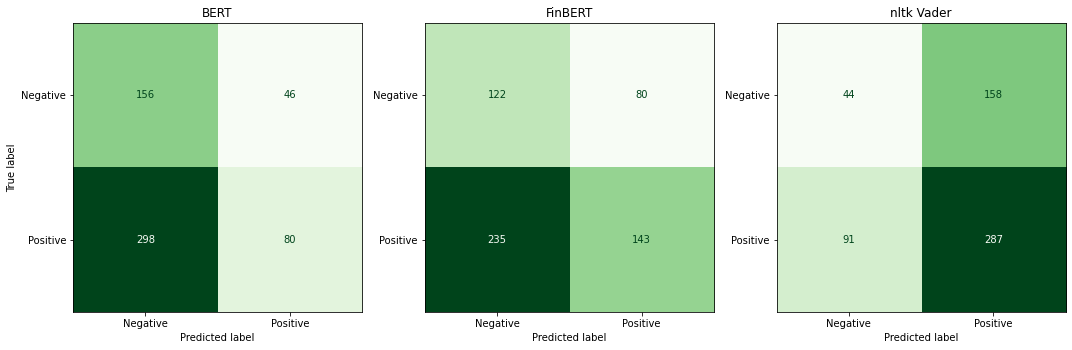

In [85]:
# confusion matrices to have an idea a more general idea about the models' performance other than simply their accuracy
# which doesn't account for the models' precision and recall 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f, axes = plt.subplots(1, 3, figsize = (15,7))

all_pred = {'BERT':bert_pred, 'FinBERT':finbert_pred, 'nltk Vader':vader.comp_score}

for i, pred in enumerate(all_pred.items()):
    cm = confusion_matrix(test_labels, pred[1], labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative','Positive'])
    disp.plot(cmap=plt.cm.Greens, ax = axes[i])
    disp.ax_.set_title(pred[0])
    disp.im_.colorbar.remove()
    if i!=0:
        disp.ax_.set_ylabel('')
    plt.tight_layout()

Along the diagonal we see the correct predictions made by each model. FinBERT improves over BERT, but both have a common issue: the models are overly labeling the tweets as negative. Vader, on the other hand, somewhat has the opposite problem and is overly predicting the positive label, though in a less strong fashion, which is eventually leading to a better performance overall.

# Task #5 : Measuring media attention <a name="task#5"></a>

## 5.1 Use the list of tickers gathered during last PC Lab (see the web-scrapping part) to compute the number of tweets about each stock

In [86]:
# for each ticker we see how many times is associated to a positive or a negative tweet, including the total
# this can be considered as a measure of media attention
# we store the result in the df dataframe
df = pd.DataFrame(columns=["positive", "negative", "total"])
for ticker in tickers:
    num_pos = sum([1 for i in data[data.Sentiment == 1].cleaned_text if re.search(f"\\b{ticker}\\b", i)])
    num_neg = sum([1 for i in data[data.Sentiment == 0].cleaned_text if re.search(f"\\b{ticker}\\b", i)])
    df.loc[ticker,:] = [num_pos, num_neg, num_pos+num_neg]
df.sort_values("total", ascending=False, inplace=True)
df.head()

,positive,negative,total
A,778,423,1201
ON,645,367,1012
AAP,484,389,873
IT,295,176,471
ARE,160,103,263


## 5.2 Rank the stocks by their amount of total media attention, positive and negative media attention

We restrict our focus on the 8 stocks analyzed in the previous two labs.

In [87]:
stocks = ["AAPL", "BA", "T", "MGM", "AMZN", "IBM", "TSLA", "GOOG"]

In [88]:
stocks_attention = df[df.index.isin(stocks)].copy()
# compute new column for % of positive and negative tweets over the total
stocks_attention.loc[:,"% pos"] = stocks_attention.apply(lambda x: np.round(x["positive"]/x["total"],2), axis = 1)
stocks_attention.loc[:,"% neg"] = stocks_attention.apply(lambda x: np.round(x["negative"]/x["total"],2), axis = 1)
stocks_attention

,positive,negative,total,% pos,% neg
GOOG,126,71,197,0.64,0.36
AMZN,64,49,113,0.57,0.43
AAPL,53,36,89,0.60,0.40
IBM,15,6,21,0.71,0.29
T,14,7,21,0.67,0.33
MGM,8,4,12,0.67,0.33
BA,6,5,11,0.55,0.45
TSLA,3,0,3,1.00,0.00


## 5.3  <font color='#cc4054'> Optional </font> : Using the stock prices data on our 8 stocks, do you see a correlation between media attention and excess return ?
- If yes, could Twitter attention is likely to be a good factor ?

In [89]:
# computing returns
def compute_returns(data):
    """
    this functions receives prices as input and computes the returns
    """
    df = pd.DataFrame(data = 0, columns=data.columns,index=data.index[1:])

    for i in tqdm(range(len(data)-1)):
        df.iloc[i] = (data.iloc[i+1] - data.iloc[i])/data.iloc[i]
      
    return df

In [5]:
# importing prices data of our 8 stocks
stocks_prices = pd.read_csv("data/lab3/Data_PCLab3_Stock.csv") 
stocks_prices["Date"] = pd.to_datetime(stocks_prices["Date"])
stocks_prices.sort_values("Date", inplace = True)
stocks_prices.set_index("Date", inplace = True)

In [91]:
stocks_8_ret = compute_returns(stocks_prices) # computing returns
stocks_8_ret = stocks_8_ret.mean(axis = 0) * 252 # finally computing an average annual return for each stock

  0%|          | 0/2158 [00:00<?, ?it/s]

In [92]:
# join returns and media attention info
stocks_attention = pd.concat([stocks_attention, stocks_8_ret], join = "inner", axis = 1).rename({0:"return"}, axis = 1)
stocks_attention

,positive,negative,total,% pos,% neg,return
GOOG,126,71,197,0.64,0.36,0.212766
AMZN,64,49,113,0.57,0.43,0.381005
AAPL,53,36,89,0.60,0.40,0.271518
IBM,15,6,21,0.71,0.29,-0.015357
T,14,7,21,0.67,0.33,0.020569
MGM,8,4,12,0.67,0.33,0.163024
BA,6,5,11,0.55,0.45,0.166162
TSLA,3,0,3,1.00,0.00,0.601041


In [93]:
def plot_media(df, metric, color = None, tick_label = True):
    title = f"{metric} attention vs returns"
    plt.title(title)
    plt.xlabel(f"{metric} attention")
    plt.ylabel("returns")
    plt.ylim(-0.1, 0.7)
    df_plot = stocks_attention.sort_values(metric).reset_index()
    if tick_label:
        for tick in df_plot["index"]:
            plt.text(df_plot[df_plot["index"] == tick].index[0],
                     df_plot[df_plot["index"] == tick]['return'] + (np.sign(df_plot[df_plot["index"] == tick]['return']))* 0.02,
                     tick, ha = "center", va = "center")
    plt.bar(df_plot.index, df_plot['return'], color = color)
    plt.xticks([]);
    

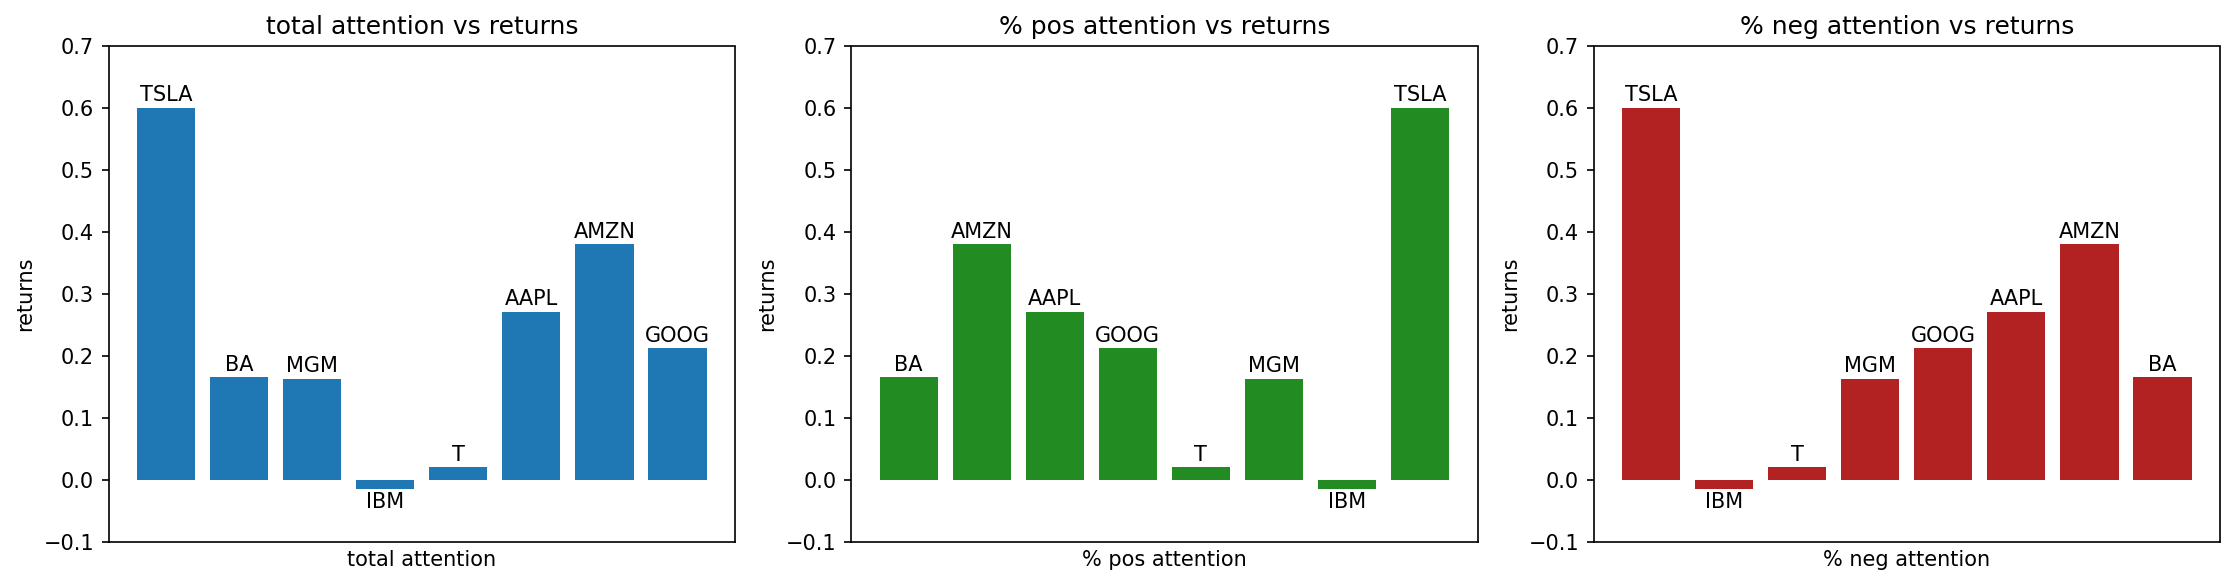

In [94]:
plt.figure(figsize = (15, 4), dpi = 150)
plt.subplot(1,3,1)
plot_media(stocks_attention, "total")
plt.subplot(1,3,2)
plot_media(stocks_attention, "% pos", color = "forestgreen")
plt.subplot(1,3,3)
plot_media(stocks_attention, "% neg", color = "firebrick")

plt.tight_layout()

This result provides a potentially useful insight as to what could be a new factor.\
The bars indicating the stock average annual return are positioned following the ranking of respective attention metric (total number of tweet mentions, % of positive and negative tweet over total mentions).\
Although total attention doesn't seem to be clearly correlated to returns (plot 1), % of positive and negative attention do correlate with stocks fluctuations. In fact, excluding Tesla (outlier both in terms of returns and media attention), as the % of positive tweets increases, on average returns decrease; on the other end, as the % of negative tweets increases, on average returns increase.\
Even though this result might seem counterintuitive, we can interpret it from risk-return trade-off perspective: firms that are negatively talked about on social media, are more likely to be considered riskier by the market and, as a consequence, to yield higher returns.